In [1]:
import My_functions as Mf
import os
import numpy as np
import matplotlib.pyplot as plt

parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different
save_folder = os.path.join(parent_folder, 'output', 'Multy')
pic_folder = os.path.join(parent_folder, 'Picture', 'alot - PTV')


frames_per_second = Mf.find_fps(pic_folder) # fps
dt = 1/frames_per_second
print('frame per second =', frames_per_second)
print('date of expirement : ', Mf.find_fps(pic_folder, '<date>'))

Mf.create_directory(save_folder)

frame per second = 60
date of expirement :  2023/11/26
the folder c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output\Multy has been created


c:\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
sphere_diamter = 9.525/1000 #[m]

In [3]:
if 'scaling_factor_PTV.pkl' in Mf.files_in_folder(save_folder, 'pkl'):
    scaling_factor = Mf.load_pickle(os.path.join(save_folder, 'scaling_factor_PTV.pkl'))
else:
    # lenghght = Mf.pixy().manual_pixel(Mf.find_pictures(pic_folder)[0], keep_same = 'y') #pixel
    lenghght = Mf.calculate_distance_between_points_napari_notebook_line(Mf.find_pictures(pic_folder)[0], initial_guess = [[368.41, 50.75], [398.41, 50.75]], title='Diameter') #pixel
    known_lenght = sphere_diamter #[m]
    scaling_factor = lenghght/known_lenght #pixel/m
    Mf.save_pickle(os.path.join(save_folder,'scaling_factor_PTV.pkl'), scaling_factor)
    print('ok')
    print(os.path.join(save_folder,'scaling_factor_PTV.pkl'))

print('Scaling factor:', scaling_factor, '[pixel/m]')

initial_guess = [[368.41, 50.75], [398.41, 50.75]]
ok
c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output\Multy\scaling_factor_PTV.pkl
Scaling factor: 3149.606299212598 [pixel/m]


choose origin

In [4]:
origin = Mf.choose_origin_napari(Mf.find_pictures(pic_folder)[0])

all the files in the directory

In [5]:
sphere_location_pixel = Mf.track_object_series(pic_folder,
                                                image_number = 669,
                                                sphere_location = [388, 560],
                                                Object_data = [[354, 525], [354, 598], [424, 598], [424, 525]],
                                                PTV_data = [[303, 0], [303, 1010], [456, 1010], [456, 0]])

use arrow keys for fine adjustments, toggle Points visability on and off to see changes 
Select the sphere, the area for PTV and the image number 
important!!! make sure the slider is on the relevant frame
image_number = 669,
sphere_location = [388, 560],
Object_data = [[354, 525], [354, 598], [424, 598], [424, 525]],
PTV_data = [[303, 0], [303, 1010], [456, 1010], [456, 0]]


display the sphere with its location

In [6]:
Mf.display_images_with_points_napari(pic_folder, sphere_location_pixel, title = 'Verify sphere location')

0

from pixel to meter

In [7]:
sphere_location_meter = Mf.transform_coordinates_pysical(sphere_location_pixel, pic_folder, scaling_factor, origin_point=origin)

skipping photos to get a reasonable velocity plot.

due to oversampling (high frame rate) the velocity uncertainty is biger than 0.1 [m/s] this is unacceptable. thus we skip photos to get a reasonable velocity uncertainty.

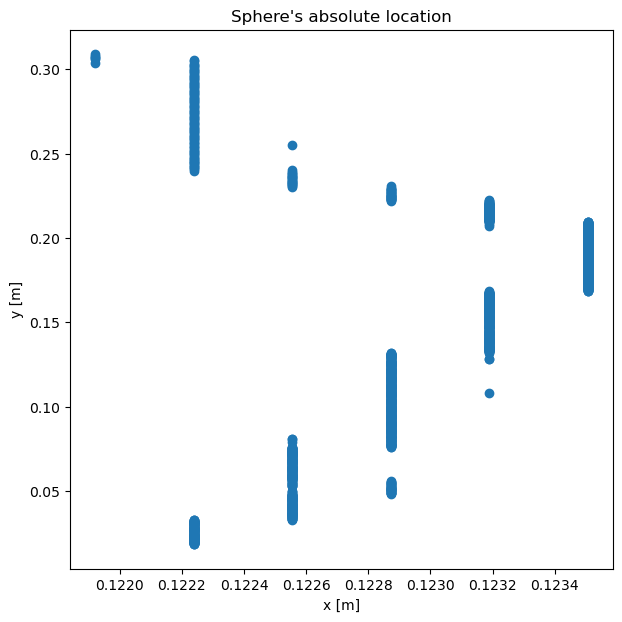

[0.1222375 0.023495 ] [0.1222375 0.018415 ]
[ 0.         -0.01102895] [-0.00033421 -0.01036053]
len 25 24
mort 24 24 0.9525000000000001 the_velocity_error_skipped   0.0003333333333333333


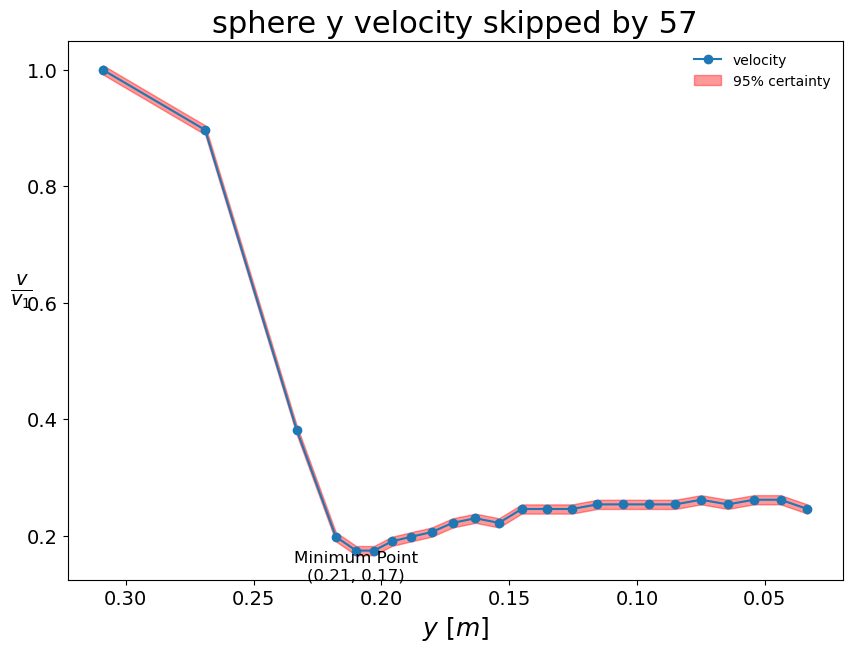

save only


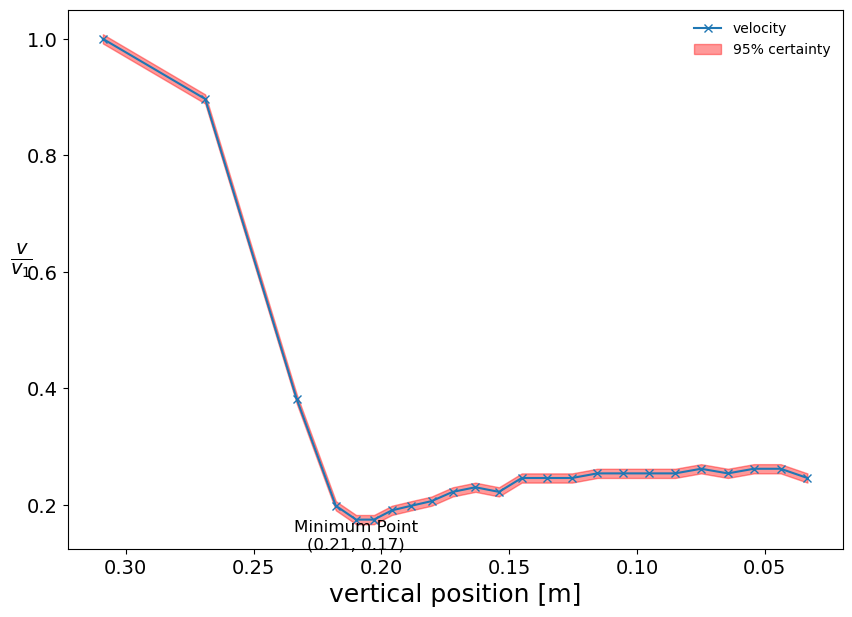

In [8]:
velocity_acceptable_error = 0.001/3 #[m/s]

sphere_location_plot = np.array(sphere_location_meter)
x_axis = sphere_location_plot[:, 0]
y_axis = sphere_location_plot[:, 1]


#plot location
fig, ax = plt.subplots(figsize=(7,7))
plt.title("Sphere's absolute location")
plt.scatter(x_axis, y_axis)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()



#getting ready for velocity
skipped_dt =  1/scaling_factor/velocity_acceptable_error #[m/s]
sphere_location_skipped_meter = Mf.skip_cells(sphere_location_meter, round(skipped_dt/dt), always_include_last = False)

print(sphere_location_skipped_meter[-1], sphere_location_meter[-1])

velocitys_skipped = Mf.calc_velocity_from_acceptable_error(sphere_location_meter, scaling_factor, dt, velocity_acceptable_error)

print(velocitys_skipped[-2], velocitys_skipped[-1])

print('len',len(sphere_location_skipped_meter), len(velocitys_skipped))




# velocities_y_skipped_meter = velocitys_skipped[:,1]
sphere_location_skipped_plot = np.array(sphere_location_skipped_meter)
sphere_velocity_skipped_plot = np.array(velocitys_skipped)
y_axis_skipped = sphere_location_skipped_plot[:, 1]
y_velocity_skipped = sphere_velocity_skipped_plot[:, 1]
the_velocity_error_skipped = 1/scaling_factor/skipped_dt #[m/s]

y_err_skipped = np.ones_like(y_velocity_skipped)*velocity_acceptable_error

print('mort', len(y_axis_skipped[:-1]), len(y_velocity_skipped), skipped_dt, 'the_velocity_error_skipped  ', velocity_acceptable_error)




v_1 = min(y_velocity_skipped)
y_velocity_skipped_normalized = y_velocity_skipped/v_1
velocity_acceptable_error_normalized = velocity_acceptable_error/v_1


y_axis_normalized = y_axis_skipped[:-1]

#plot velocity
fig, ax = plt.subplots(figsize=(10, 7))
plt.title("sphere y velocity skipped by "+str(round(skipped_dt/dt)), fontsize = 22)
plt.plot(y_axis_normalized, y_velocity_skipped_normalized,'-o', label='velocity')
plt.fill_between(y_axis_normalized, y_velocity_skipped_normalized + velocity_acceptable_error_normalized,
                  y_velocity_skipped_normalized - velocity_acceptable_error_normalized, color='r', alpha=0.4, label='95% certainty')
# Add text at the minimum point
min_index = np.argmin(y_velocity_skipped_normalized)
plt.text(y_axis_normalized[min_index], y_velocity_skipped_normalized[min_index],
        f'Minimum Point\n({y_axis_normalized[min_index]:.2f}, {y_velocity_skipped_normalized[min_index]:.2f})', 
        horizontalalignment='center', verticalalignment='top', fontsize=12)
plt.xlabel(r'$\mathit{y}\ [m]$', fontsize = 18)
plt.ylabel(r'$\mathit{\frac{v} {v_{1}}}$', fontsize = 20, rotation=0)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.gca().invert_xaxis()
plt.legend(fancybox=True, framealpha=0)
plt.show()



print('save only')
#plot velocity again just for saving fig with no title
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(y_axis_normalized, y_velocity_skipped_normalized,'-x', label='velocity')
plt.fill_between(y_axis_normalized, y_velocity_skipped_normalized + velocity_acceptable_error_normalized,
                  y_velocity_skipped_normalized - velocity_acceptable_error_normalized, color='r', alpha=0.4, label='95% certainty')

# Add text at the minimum point
min_index = np.argmin(y_velocity_skipped_normalized)
plt.text(y_axis_normalized[min_index], y_velocity_skipped_normalized[min_index],
        f'Minimum Point\n({y_axis_normalized[min_index]:.2f}, {y_velocity_skipped_normalized[min_index]:.2f})', 
        horizontalalignment='center', verticalalignment='top', fontsize=12)

plt.xlabel(r'$\mathit{\frac{y} {h}}$', fontsize = 18)
plt.xlabel('vertical position [m]', fontsize = 18)
plt.ylabel(r'$\mathit{\frac{v} {v_{1}}}$', fontsize = 20, rotation=0)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.gca().invert_xaxis()
plt.legend(fancybox=True, framealpha=0)
plt.savefig(os.path.join(save_folder, 'sphere velocity PTV.svg'), transparent=True, bbox_inches='tight')

We skipped alot of pictures, thus we have less data point. the next function fills the missing data points with interplation between pair of points.

In [9]:
sphere_location_skipped_meter = Mf.skip_cells(sphere_location_meter, round(skipped_dt/dt))
velocitys_skipped = Mf.calc_velocity_from_acceptable_error(sphere_location_meter, scaling_factor, dt, velocity_acceptable_error)
y_velocity_skipped_added_point = np.append(velocitys_skipped, [velocitys_skipped[-1]], axis=0)
velocitys_meter = Mf.interpolate_between_points_2d(sphere_location_skipped_meter, y_velocity_skipped_added_point, sphere_location_meter, factor = round(skipped_dt/dt))
if len(velocitys_meter)<len(sphere_location_meter):
    velocitys_meter = np.vstack([velocitys_meter, np.tile(velocitys_meter[-1], (len(sphere_location_meter)-len(velocitys_meter), 1))])
    print(f'The last {len(sphere_location_meter)-len(velocitys_meter)+1:.2f} Point were added to the velocity to match y_axis lenght. thier value is:', velocitys_meter[-1].tolist())

The last 1.00 Point were added to the velocity to match y_axis lenght. thier value is: [-0.00033421052631578776, -0.010360526315789478]


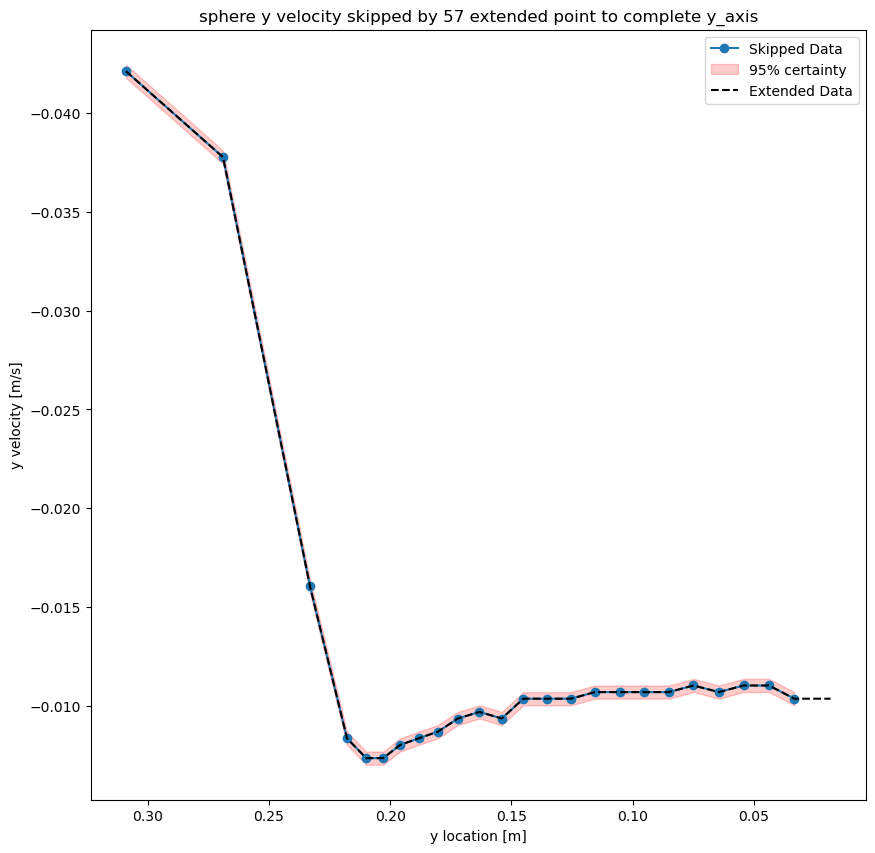

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title("sphere y velocity skipped by "+str(round(skipped_dt/dt)) + ' extended point to complete y_axis')
plt.plot(y_axis_skipped[:-1], y_velocity_skipped, 'o-', label='Skipped Data')
plt.fill_between(y_axis_skipped[:-1], y_velocity_skipped + velocity_acceptable_error, y_velocity_skipped - velocity_acceptable_error, color='red', alpha=0.2, label='95% certainty')
plt.plot(sphere_location_meter[:,1], velocitys_meter[:,1], '--', color = 'black', label='Extended Data')

ax.set_xlabel('y location [m]')
ax.set_ylabel('y velocity [m/s]')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

# Save
y axis is positive upwards.

+ sphere_location_meter - the sphere aboslute location in meters [m] relative to bottom left corner, the origin.
+ velocitys_meter - sphere velocity in [m/s] SI units


In [11]:
file_path = os.path.join(save_folder, 'data_from_PTV.pkl')
Mf.save_pickle(file_path, [sphere_location_meter, velocitys_meter])

חלק חדש
אמור לשים את הנקודה במרכז הכדור

In [12]:
# from pprint import pprint
# new_sphere_location = []
# for i in range(len(sphere_location)):
#     new_sphere_location.append(Mf.enhance_coordinates(Mf.find_pictures(pic_folder, True)[i], sphere_location[i], bias = 36))
#     pprint((sphere_location[i][1], new_sphere_location[i][1]))